# Quantifying Bias in Library Classification Systems
Notebook to generate the results found in the paper "Quantifying Bias in Hierarchical Category Systems". 

Some of the permutation tests for this analyses are slow to run, and have been turned off. To run the permutation tests set permTest variables to True.

## Attributions
This project contains information from [OhioLINK Circulation Data](https://www.oclc.org/research/areas/systemwide-library/ohiolink/circulation.html) which is made available by OCLC Online Computer Library Center, Inc. and OhioLINK under the [ODC Attribution License]( https://www.oclc.org/research/areas/systemwide-library/ohiolink/odcby.html).


## Imports

In [1]:
# Custom python code for analysis
import LibraryTree as lt
import WesternTagging as wt
import CategoryBias as cb
import ItemBias as ib

# Python Libraries
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from tabulate import tabulate

In [2]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['font.stretch'] = 'condensed'
mpl.rcParams["font.family"] = 'DejaVu Sans'

## Preliminaries

Build the LCC and DDC data structures

In [3]:
folder = 'Data\\Library Data\\'
lccTree = lt.LCCTree(folder + 'LCC Outlines')
ddcTree = lt.DDCTree(folder + 'DDC')
lcc_root = lccTree.root
ddc_root = ddcTree.root

print(f'There are {lccTree.node_count:,} nodes in the LCC and {ddcTree.node_count:,} nodes in the DDC.')

There are 6,870 nodes in the LCC and 33,751 nodes in the DDC.


Load and process MARC records

In [4]:
file = 'Data\\OhioLINK Data\\marcData.pk'
with open (file, 'rb') as f:
    bookData = pickle.load(f)

print(f'There are {len(bookData):,} MARC records.')

There are 6,779,969 MARC records.


In [5]:
noLCC = len([1 for item in bookData if item['lcc'] is None])
multiLCC = len([1 for item in bookData if item['lcc'] is not None and len(item['lcc']) > 1])

noDDC = len([1 for item in bookData if item['ddc'] is None])
multiDDC = len([1 for item in bookData if  item['ddc'] is not None and len(item['ddc']) > 1])

bookData = lt.extract_class_num(bookData)

In [6]:

# ensure the DDC and LCC numbers are in the correct format
validLCC = [book for book in bookData if book['lcc'] is not None and lccTree.validate_lcc(book['lcc'])]
validDDC = [book for book in bookData if book['ddc'] is not None and lt.validate_ddc(book['ddc'])]

table = [["Library of Congress", len(validLCC), len(bookData) - (len(validLCC) + noLCC), noLCC, multiLCC]]
print(tabulate(table, headers=["", "Valid LCC",\
                               "Invalid LCC",\
                               "No LCC", \
                               "Multiple LCCs "]))

print("")
table = [["Dewey Decimal System", len(validDDC),  len(bookData) - (len(validDDC) + noDDC), noDDC, multiDDC]]
print(tabulate(table, headers=["", "Valid DDC",\
                                "Invalid DDC", \
                               "No DDC", \
                               "Multiple DDCs "]))

                       Valid LCC    Invalid LCC    No LCC    Multiple LCCs
-------------------  -----------  -------------  --------  ----------------
Library of Congress      5779399          18313    982257            177964

                        Valid DDC    Invalid DDC    No DDC    Multiple DDCs
--------------------  -----------  -------------  --------  ----------------
Dewey Decimal System      3514438          99431   3166100            183550


Populate the LCC and DDC with books. Only books with a classification number in both systems are used.

In [ ]:
lcc_nums = [dat['oclc'] for dat in validLCC]
ddc_nums = [dat['oclc'] for dat in validDDC]
intersect = set.intersection(set(lcc_nums), set(ddc_nums))
validLCC = [dat for dat in validLCC if dat['oclc'] in intersect]
lccTree.add_books(validLCC)
lcc_nums = [item['oclc'] for item in lccTree.root.items]
intersect = set.intersection(set(lcc_nums), set(ddc_nums))
validDDC = [dat for dat in validDDC if dat['oclc'] in intersect]
ddcTree.add_books(validDDC)
print(f'There are {len(ddcTree.root.items):,} books with both a DDC and LCC classification number.')

In [ ]:
del validDDC, validLCC, intersect, lcc_nums, ddc_nums, bookData

## Study 1: Western Category Bias

Computes category count bias, category level bias, and descendant bias in the  Library of Congress Classification (LCC) and the Dewey Decimal Classification (DDC).


### Tagging
Count and collect all the nodes for the topics Religion, History, and Language & Literature. These are all the nodes that can potentially be tagged.

In [ ]:
# History
hist_lcc = [lcc_root.children['D'], lcc_root.children['E'], lcc_root.children['F']]
hist_ddc = [ddc_root.children['9']]
# Religion
relig_lcc = [lcc_root.children['B']]
relig_ddc = [ddc_root.children['2']]
# Language & Literature 
ll_lcc = [lcc_root.children['P']]
ll_ddc = [ddc_root.children['4'], ddc_root.children['8']]

#Collect LCC Nodes
ll_count_lcc = cb.get_total_nodes(ll_lcc)
relig_count_lcc = cb.get_total_nodes([lccTree.hash_table['B'][f'B{sub_cat}']['node'] for sub_cat in 'LMPQRSTVX']) # not all of B is for religion
hist_count_lcc = cb.get_total_nodes(hist_lcc)
total_lcc = ll_count_lcc + relig_count_lcc + hist_count_lcc
print(f'LCC: {total_lcc}\n\tReligion: {relig_count_lcc} nodes\n\tLang. & Lit.: {ll_count_lcc} nodes\n\tHistory: {hist_count_lcc} nodes')

ll_count_ddc = cb.get_total_nodes(ll_ddc)
relig_count_ddc = cb.get_total_nodes(relig_ddc)
hist_count_ddc = cb.get_total_nodes([ddcTree.get_node(cat) for cat in ['90', '93', '94', '95', '96', '97', '98', '99']]) # not all of 9 is for history 

total_ddc = ll_count_ddc + relig_count_ddc + hist_count_ddc
print(f'DDC: {total_ddc:,}\n\tReligion: {relig_count_ddc} nodes\n\tLang. & Lit.: {ll_count_ddc} nodes\n\tHistory: {hist_count_ddc} nodes')

LCC: 3009
	Religion: 571 nodes
	Lang. & Lit.: 920 nodes
	History: 1518 nodes
DDC: 13,536
	Religion: 2420 nodes
	Lang. & Lit.: 7758 nodes
	History: 3358 nodes


Tag and collect western and non-western nodes

In [ ]:
wt.tag_lcc(lccTree)
wt.tag_dewey(ddcTree)

In [ ]:
# History in the LCC
west_hist_lcc = []
wt.parse_west_data(hist_lcc[0], True, west_hist_lcc)
wt.parse_west_data(hist_lcc[1], True, west_hist_lcc)
wt.parse_west_data(hist_lcc[2], True, west_hist_lcc)
non_west_hist_lcc = [] 
wt.parse_west_data(hist_lcc[0], False, non_west_hist_lcc)
# History in the DDC
west_hist_ddc = []
wt.parse_west_data(hist_ddc[0], True, west_hist_ddc)
non_west_hist_ddc = [] 
wt.parse_west_data(hist_ddc[0], False, non_west_hist_ddc)

# Religion in the LCC
west_relig_lcc = []
wt.parse_west_data(relig_lcc[0], True, west_relig_lcc)
non_west_relig_lcc = [] 
wt.parse_west_data(relig_lcc[0], False, non_west_relig_lcc)
# Religion in the DDC
west_relig_ddc = []
wt.parse_west_data(relig_ddc[0], True, west_relig_ddc)
non_west_relig_ddc = [] 
wt.parse_west_data(relig_ddc[0], False, non_west_relig_ddc)

# Language and Literature in the LCC
west_ll_lcc = []
wt.parse_west_data(ll_lcc[0], True, west_ll_lcc)
non_west_ll_lcc = [] 
wt.parse_west_data(ll_lcc[0], False, non_west_ll_lcc)
# Language and Literature in the DDC
west_ll_ddc = []
wt.parse_west_data(ll_ddc[0], True, west_ll_ddc)
wt.parse_west_data(ll_ddc[1], True, west_ll_ddc)
non_west_ll_ddc = [] 
wt.parse_west_data(ll_ddc[0], False, non_west_ll_ddc)
wt.parse_west_data(ll_ddc[1], False, non_west_ll_ddc)

In [ ]:
WEST = [[west_relig_lcc, west_ll_lcc, west_hist_lcc], [west_relig_ddc, west_ll_ddc, west_hist_ddc]]
NON_WEST = [[non_west_relig_lcc, non_west_ll_lcc, non_west_hist_lcc], [non_west_relig_ddc, non_west_ll_ddc, non_west_hist_ddc]]
NAMES = ['Religion', 'Lang. & Lit.', 'History', 'Overall']
SYSTEMS = ['LCC', 'DDC']

### Count Bias
There are more western than non-western nodes for the topics Religion, History, and Language & Literature in both the DDC and LCC.

In [ ]:
num_w_lcc = sum([len(cat) for cat in WEST[0]])
num_nw_lcc = sum([len(cat) for cat in NON_WEST[0]])
num_tagged_lcc = num_w_lcc + num_nw_lcc
print(f'There are {num_tagged_lcc:,} ({round(num_tagged_lcc/total_lcc*100, 1)}%) tagged nodes in the LCC and {round((num_w_lcc/num_tagged_lcc)*100, 2)}% are Western')

num_w_ddc =  sum([len(cat) for cat in WEST[1]])
num_nw_ddc = sum([len(cat) for cat in NON_WEST[1]])
num_tagged_ddc= num_w_ddc + num_nw_ddc
print(f'There are {num_tagged_ddc:,} ({round(num_tagged_ddc/total_ddc*100, 1)}%) tagged nodes in the LCC and {round((num_w_ddc/num_tagged_ddc)*100, 2)}% are Western')

There are 2,598 (86.3%) tagged nodes in the LCC and 62.24% are Western
There are 12,372 (91.4%) tagged nodes in the LCC and 69.35% are Western


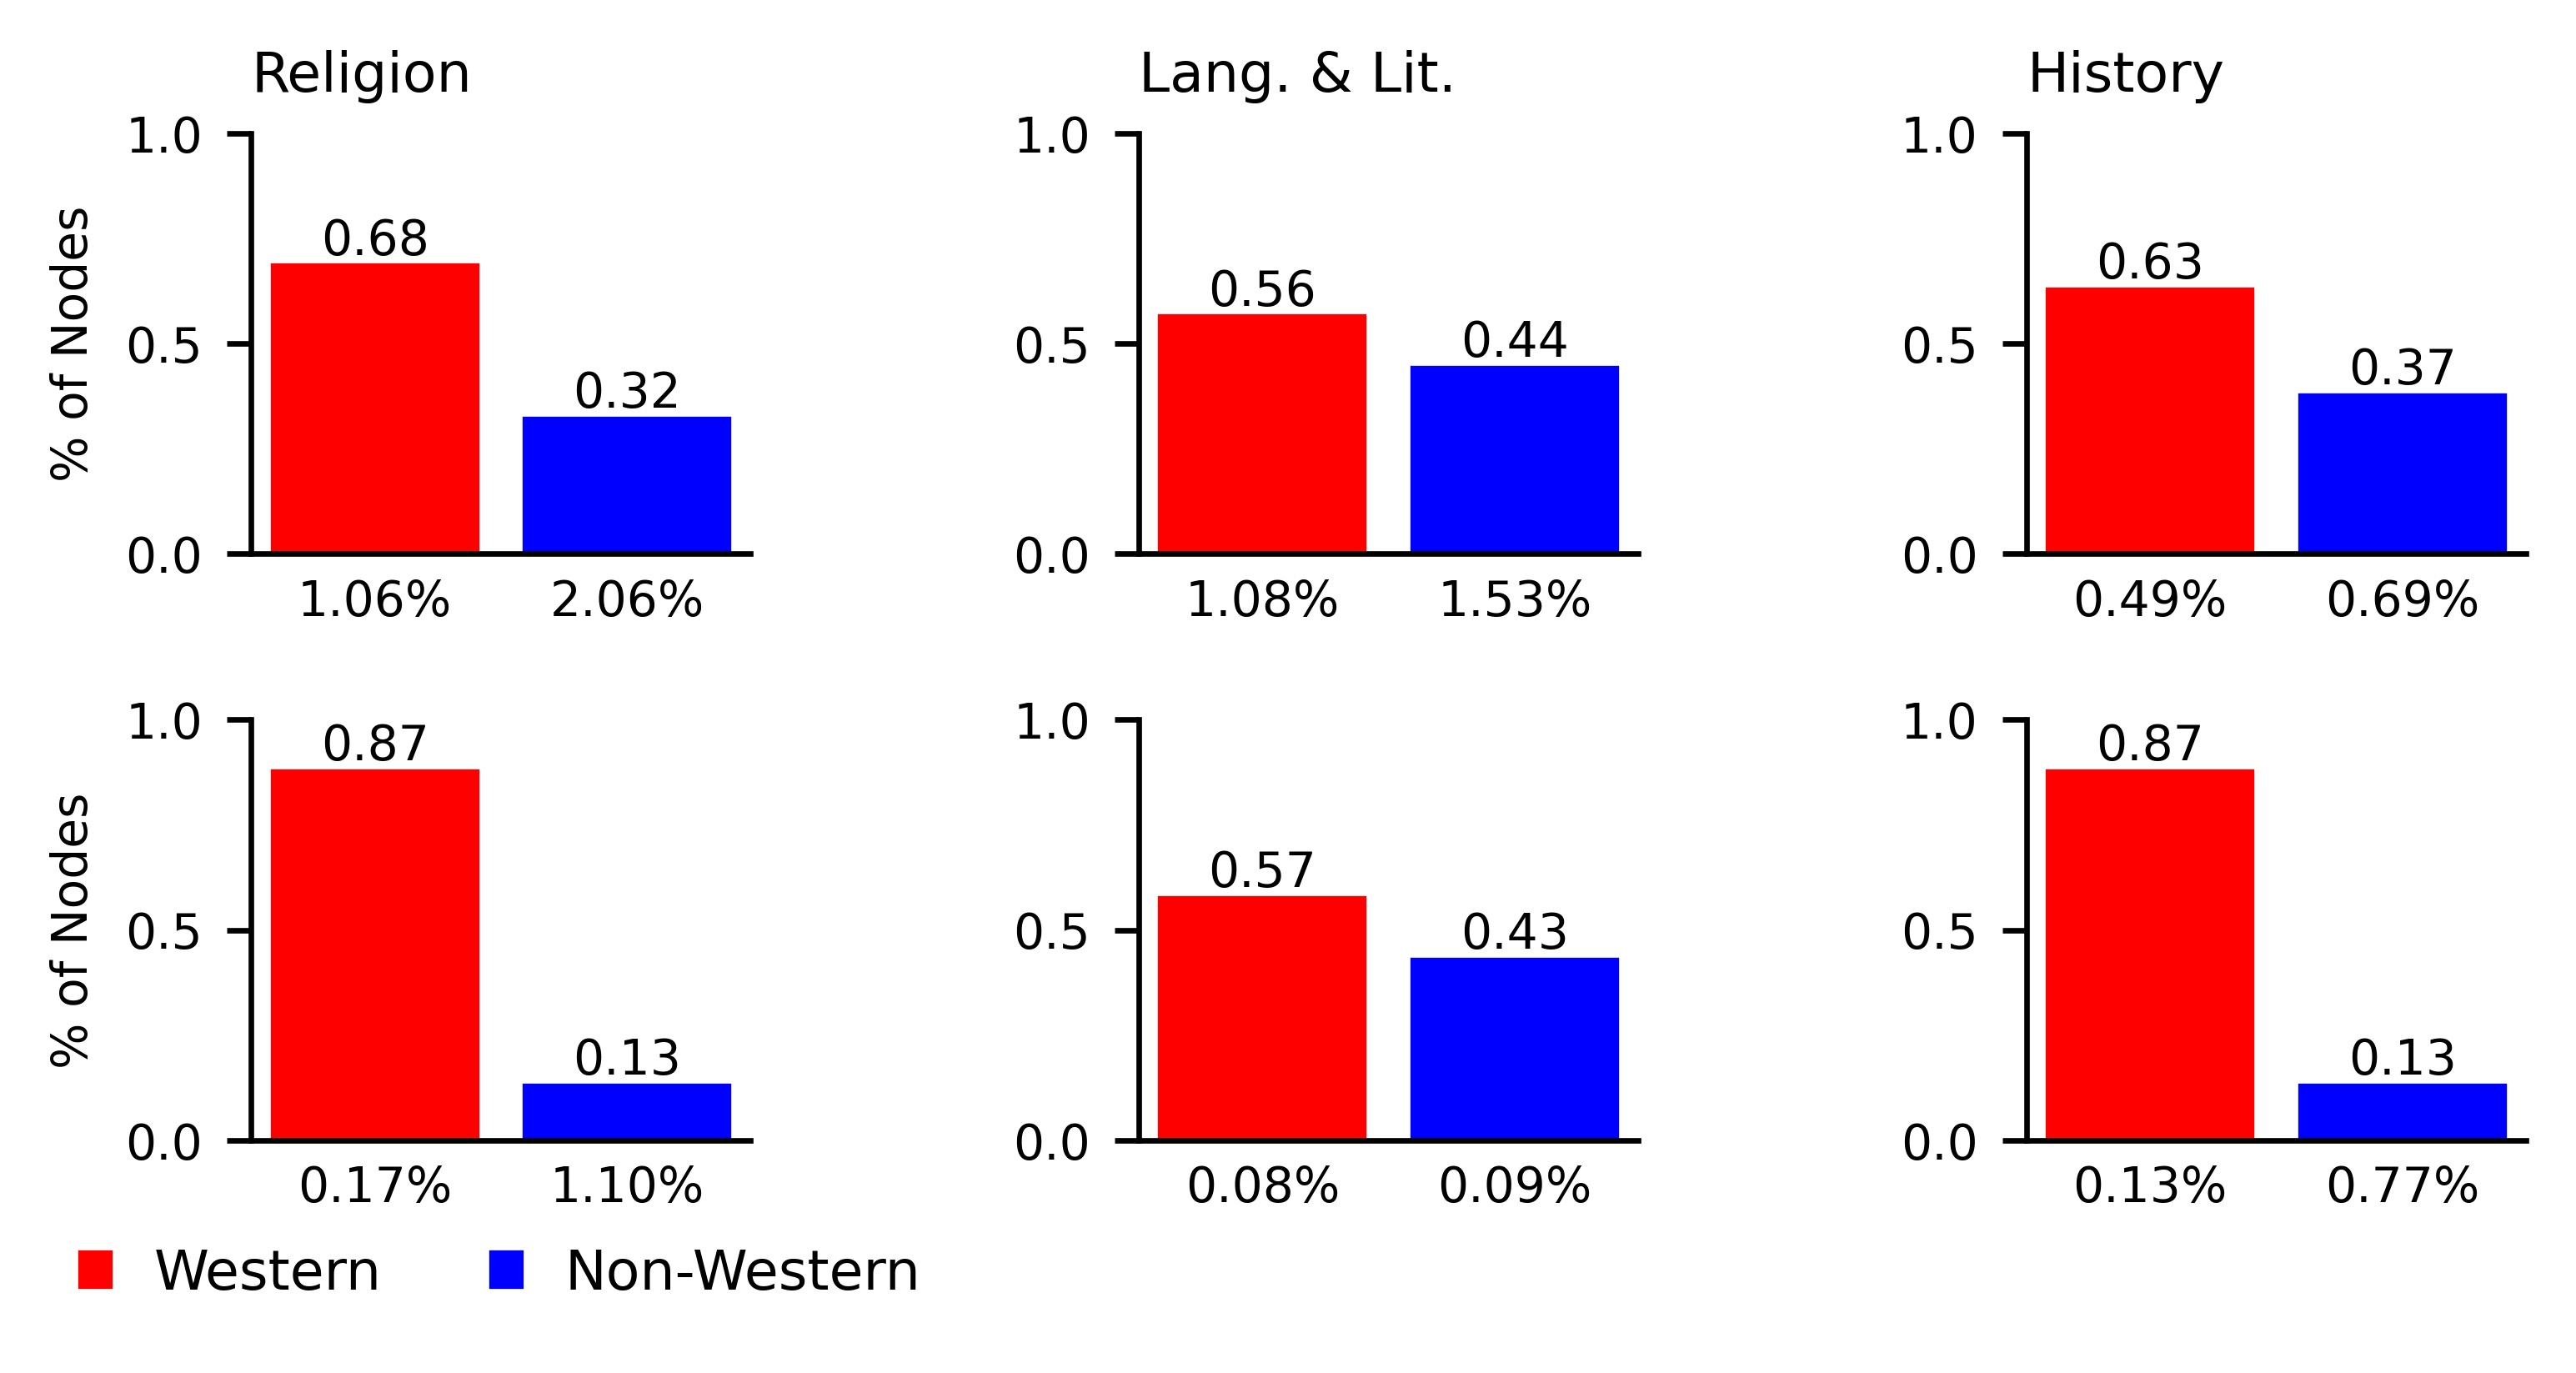

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(5.25, 2.9), dpi=600.0)
plt.setp(axes, ylim=[0, 1], xticks=[0, 1], yticks=[0, 0.5, 1])
x = [0, 1]
for i in range(2):
    for j in range(3):
        # Calculate node count
        w_count = len(WEST[i][j])
        nw_count = len(NON_WEST[i][j])
        total = w_count + nw_count
        y = [w_count/total, nw_count/total]
        # Get average % items per node
        w_items_rate = cb.avg_items_per_node(WEST[i][j])
        nw_item_rate = cb.avg_items_per_node(NON_WEST[i][j])
        item_rates = [f'{round(w_items_rate*100, 2):.2f}%', f'{round(nw_item_rate*100, 2):.2f}%']
        # Plot
        ax = axes[i][j]
        bar = ax.bar(x, y)
        bar[0].set_color('r'), bar[1].set_color('b')
        ax.tick_params(axis='both', labelsize=7)
        ax.tick_params(axis='x', which='both', length=0)
        # ax.set_xticklabels(item_rates, fontsize=7)
        # for k in range(len(y)):
        #     ax.text(x=x[k], y=y[k] + 0.03,
        #             s=f"{round(y[k], 2):.2f}",fontdict=dict(fontsize=7), ha='center')
        if i == 0:
            ax.set_title(NAMES[j], fontsize=8, loc='left')
        if j != 0:
            ax.tick_params(axis='y', which='both', length=0)
            ax.set_yticks([]) 
        axes[i][0].set_ylabel('% of Nodes', fontsize=7)
legend_elements = [Patch(facecolor='r', edgecolor='r', label='Western'),
                   Patch(facecolor='b', edgecolor='b', label='Non-Western')]
axes[1][0].legend(handles=legend_elements, fontsize=8, handleheight=0.5, handlelength=0.5, 
                  loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=2, frameon=False)
plt.subplots_adjust(wspace=0.5, 
                    hspace=0.35)
fig.tight_layout()

#### Permutation Test

In [42]:
permTest = False
if permTest:
    for i in range(2):
        print(SYSTEMS[i])    
        for j in range(3):
            w_counts = len(WEST[i][j])
            nw_counts = len(NON_WEST[i][j])
            p_val = cb.category_perm_test(w_counts, nw_counts, 10000)
            print(f'{NAMES[j]}: {round(p_val, 3)}')
        print("")

### Level Bias

Non-western nodes tend to be deeper in the library classification systems than non-western nodes. This effect is more prominent in the DDC.

#### Level Bias Analysis 1

Average Depth of Western and Non-Western nodes

In [16]:
table = [[], [], [], [], [], [], [], [], [], [], [], []]
for j in range(2):
    lib = SYSTEMS[j]
    for i in range(4):
        if i == 3:
            west, nonwest = sum(WEST[j], []), sum(NON_WEST[j], [])
        else:
            west, nonwest = WEST[j][i], NON_WEST[j][i]
        if j == 0:
            idx = i*3
        else:
            idx = (i*3) + 1
        # Average Depth
        avg_w, avg_nw = cb.level_bias1(west, nonwest)
        table[idx] += [NAMES[i], lib, f'{round(avg_w, 2):.2f}', f'{round(avg_nw, 2):.2f}']
print(tabulate(table, headers=['', '', 'Avg. W Depth', 'Avg. NW Depth']))

                     Avg. W Depth    Avg. NW Depth
------------  ---  --------------  ---------------
Religion      LCC            2.75             4.14
Religion      DDC            2.56             3.82

Lang. & Lit.  LCC            2.18             3.33
Lang. & Lit.  DDC            2.83             3.66

History       LCC            2.12             2.8
History       DDC            2.82             2.71

Overall       LCC            2.28             3.35
Overall       DDC            2.77             3.57



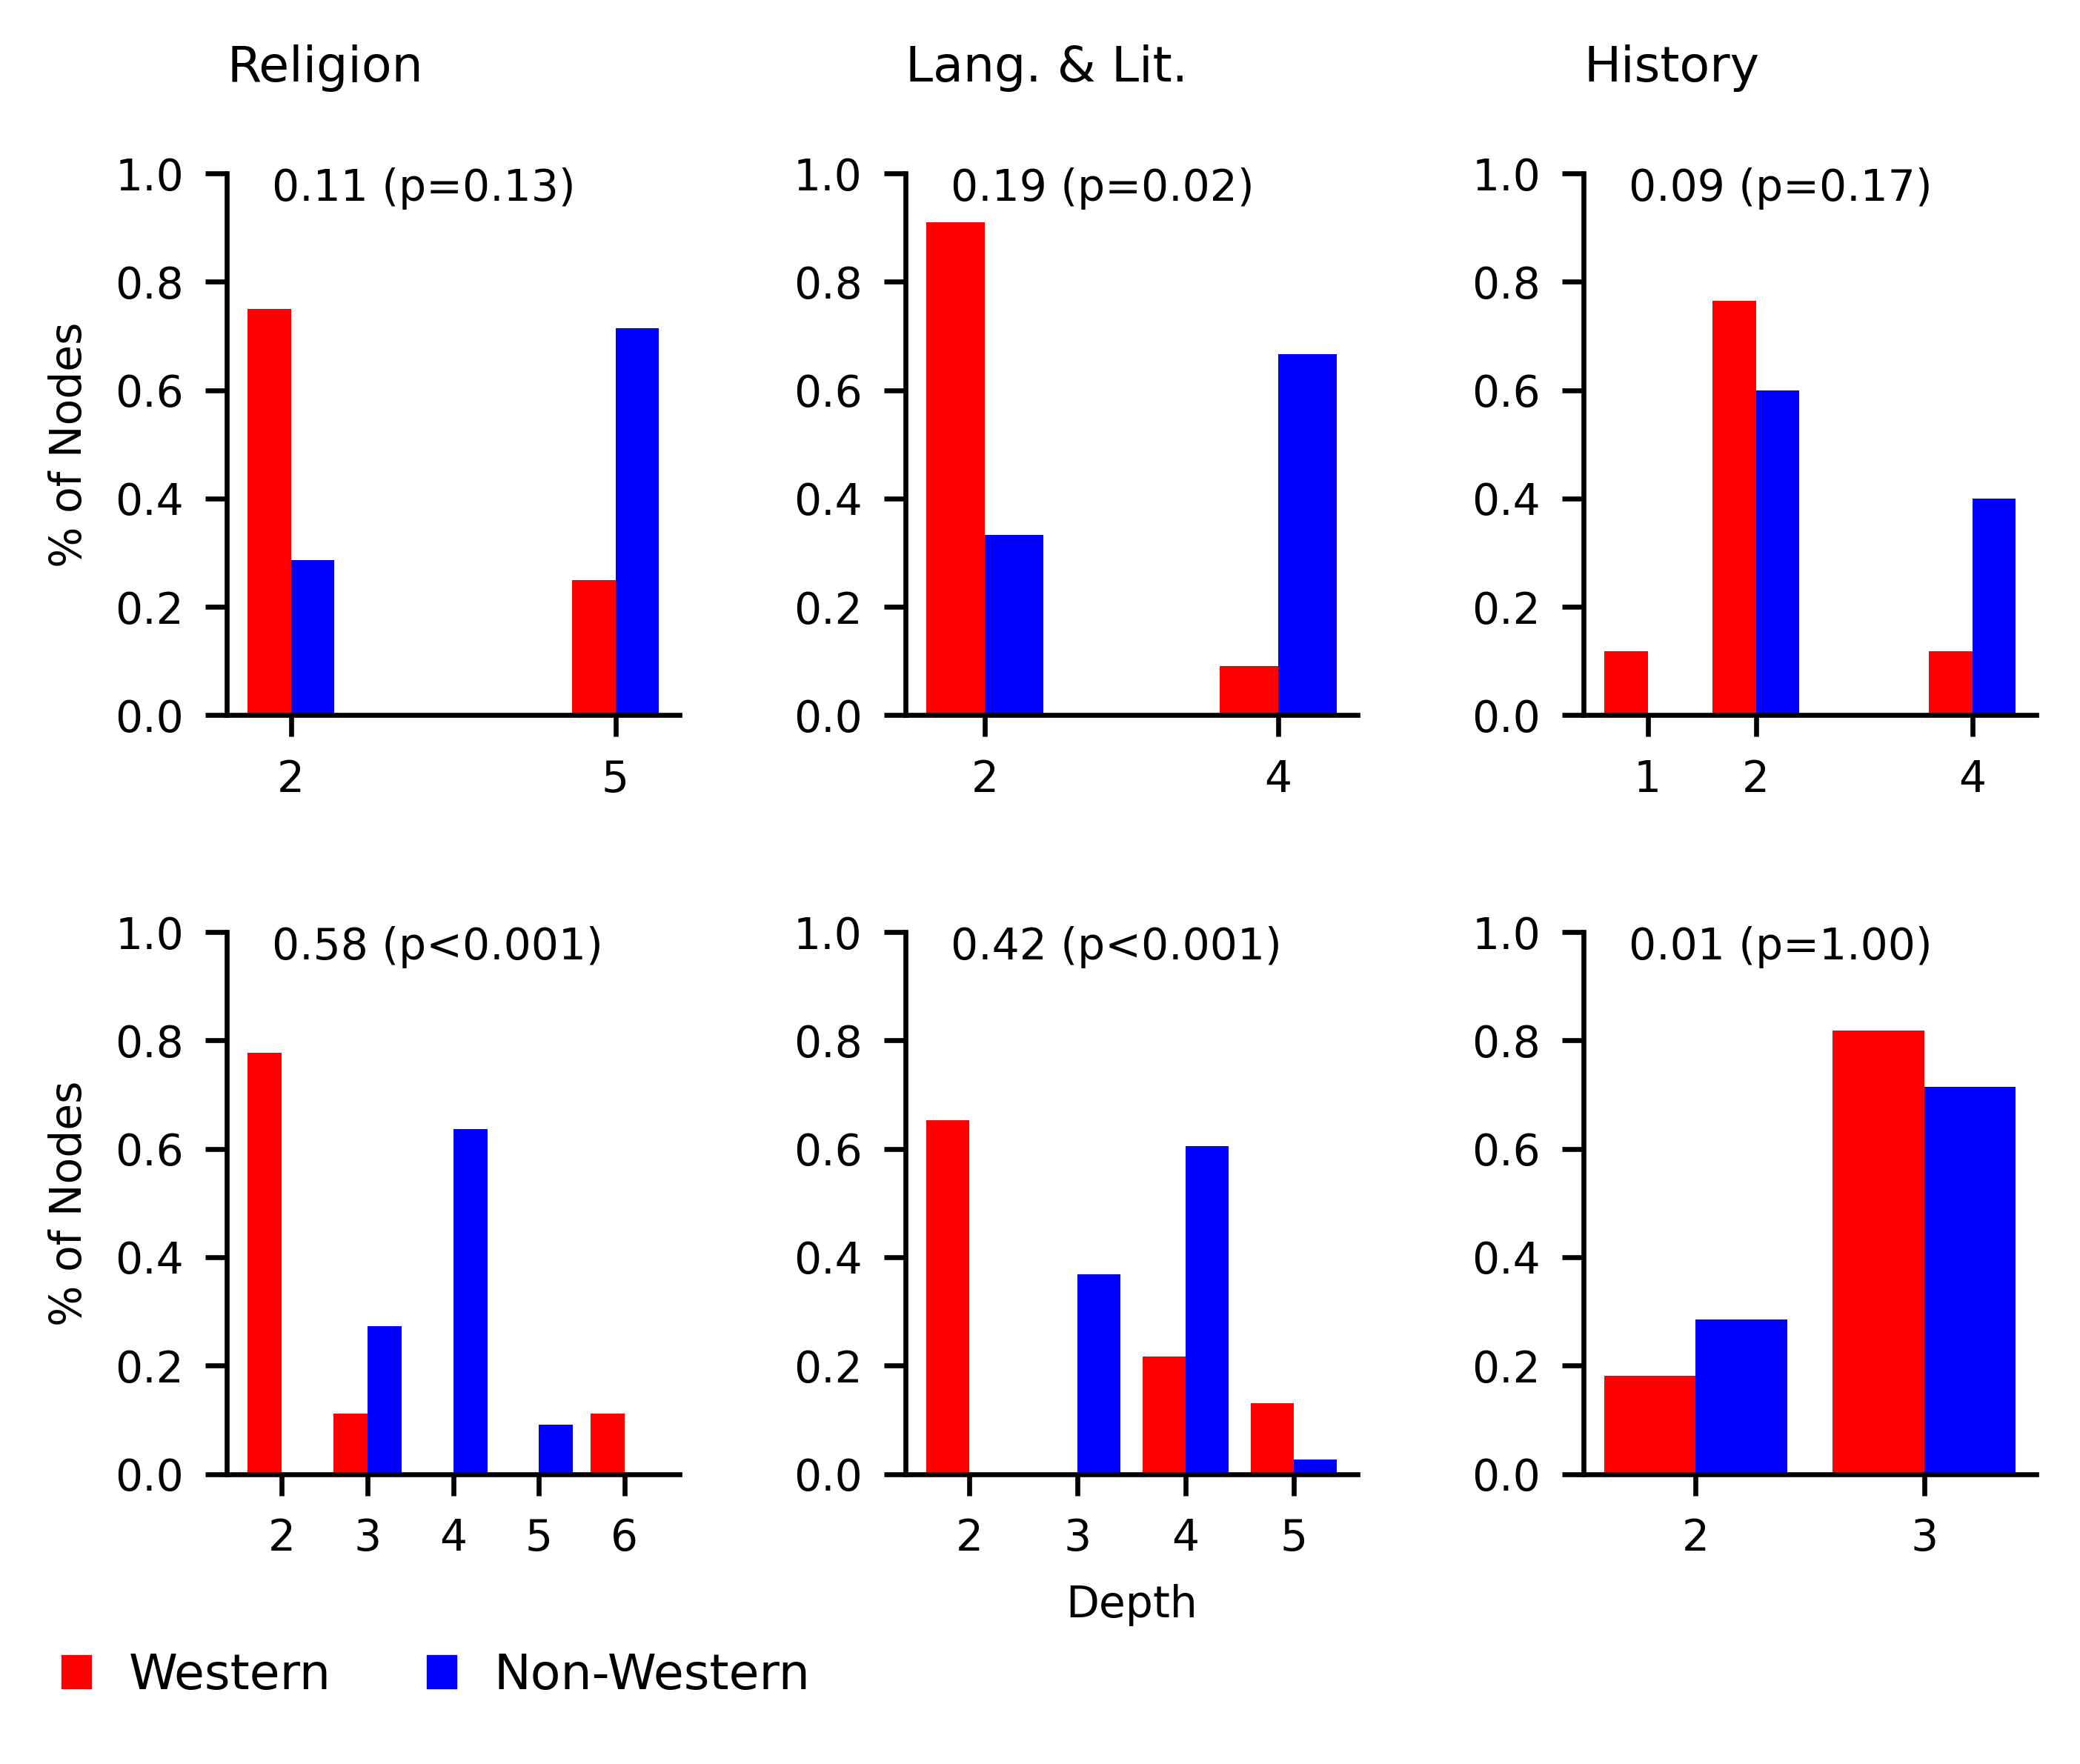

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(5.25, 3.8), dpi=600.0)
plt.setp(axes, ylim=[0, 1])
width = 0.4
for j in range(2):
    for i in range(3):
        # Calculate level distribution
        w_levels = cb.get_level_dist(WEST[j][i])
        nw_levels = cb.get_level_dist(NON_WEST[j][i])
        levels = list(set(w_levels + nw_levels))
        # Calculate jensen-shannon divergence
        jsd = cb.get_jsd(w_levels, nw_levels)
        # Perform permutation test
        p_val = cb.level_perm_test1(w_levels+nw_levels, len(w_levels), jsd, 10000)
        # Plot level bias data, 2
        w_dist = [w_levels.count(lev)/len(w_levels) for lev in levels]
        nw_dist = [nw_levels.count(lev)/len(nw_levels) for lev in levels]
        ax = axes[j][i]
        ax.bar([i - width/2 for i in levels], w_dist, width, label=f'Western',
                color='red')
        ax.bar([i + width/2 for i in levels] , nw_dist, width, label=f'Non-Western',
                color='blue')
        ax.tick_params(axis='both', labelsize=7)
        ax.set_xticks(levels)
        if p_val < 0.001:
            p_val = '(p<0.001)'
        else:
            p_val = f'(p={round(p_val, 2):.2f})'
        ax.text(0.1, 0.95, f'\n{jsd:.2f} {p_val}', ha='left', fontsize=7, 
                transform = ax.transAxes)
        if j == 0:
            ax.set_title(f'{NAMES[i]}\n', fontsize=8, loc='left')
    axes[j][0].set_ylabel('% of Nodes', fontsize=7)
axes[1][1].set_xlabel('Depth', fontsize=7)
legend_elements = [Patch(facecolor='r', edgecolor='r', label='Western'),
                        Patch(facecolor='b', edgecolor='b', label='Non-Western')]
fig.legend(handles=legend_elements, fontsize=8, handleheight=0.5, handlelength=0.5, 
                loc="lower center", ncol=2, bbox_to_anchor=(0.215, -0.05), frameon=False)
plt.subplots_adjust(wspace=0.5, 
                    hspace=0.4)

#### Level Bias Analysis 2
The probability that a non-western node is deeper in the category system

In [52]:
def level_bias2(west, nonwest, permTest=False, perms=0):
    starting_w = [node['depth'] for node in west if node['parent'] is None 
                        or node['parent'].west is None]
    starting_nw = [node['depth'] for node in nonwest if node['parent'] is None 
                        or node['parent'].west is None]
    prob_nw = cb.prob_non_west_deeper(starting_w, starting_nw, 100000)    
    if permTest:
        p_val = cb.level_perm_test2(starting_w + starting_nw, len(starting_w), prob_nw, perms)
        return prob_nw, p_val
    else:
        return prob_nw, None

In [69]:
permTest = True
for i in range(2):
    print(SYSTEMS[i])  
    for j in range(3):
        if j == 3:
            west, nonwest = sum(WEST[i], []), sum(NON_WEST[i], [])
        else:
            west, nonwest = WEST[i][j], NON_WEST[i][j]
        if permTest:
            prob_nw, p_val = level_bias2(west, nonwest, permTest, 10000)
            print(f'{NAMES[j]}: {round(prob_nw, 2)}, (p = {round(p_val, 2)})')
        else:
            prob_nw, _ = level_bias2(west, nonwest)
            print(f'{NAMES[j]}: {round(prob_nw, 2)}')
    print("")

LCC
Religion: 0.88, (p = 0.11)
Lang. & Lit.: 0.95, (p = 0.02)
History: 0.86, (p = 0.06)

DDC
Religion: 0.88, (p = 0.02)
Lang. & Lit.: 0.75, (p = 0.01)
History: 0.37, (p = 0.96)



### Descendant Bias

The DDC tends to have more descendants per western starting node than non-western starting node. The LCC does not show any descendant bias.

In [41]:
labels = ["",  "", "# of\nstart\nnodes", "% of \nbooks per\nstart node",
           "Avg. # of\nchildren per\nstart node", "\n\np_val"]
for i in range(2):
    print(SYSTEMS[i])  
    table = []
    for j in range(4):
        if j == 3:
            west, nonwest = sum(WEST[i], []), sum(NON_WEST[i], [])
        else:
            west, nonwest = WEST[i][j], NON_WEST[i][j]
        w_desc, w_count = cb.avg_descendants(west)
        nw_desc, nw_count = cb.avg_descendants(nonwest)
        w_per_start = cb.mean_items_per_start(west)
        nw_per_start = cb.mean_items_per_start(nonwest)
        p_val = cb.desc_perm_test(west, nonwest, 10000)
        table += [['', 'W', w_count, round(w_per_start*100, 1), round(w_desc, 1), ''], 
                  [NAMES[j], 'NW', nw_count, round(nw_per_start*100, 1), round(nw_desc, 1), round(p_val, 2)], 
                  ['------------', '--', '-------', '------------', '--------------', '-------']]
    print(tabulate(table, headers=labels))
    print("\n")        

LCC
                  # of     % of          Avg. # of
                  start    books per     children per
                  nodes    start node    start node      p_val
------------  --  -------  ------------  --------------  -------
              W   8        12.5          44.5
Religion      NW  7        14.3          23.3            0.44
------------  --  -------  ------------  --------------  -------
              W   11       9.1           29.2
Lang. & Lit.  NW  9        11.1          27.9            0.92
------------  --  -------  ------------  --------------  -------
              W   17       5.9           53.2
History       NW  10       10.0          54.1            0.97
------------  --  -------  ------------  --------------  -------
              W   36       2.8           43.9
Overall       NW  26       3.8           36.7            0.59
------------  --  -------  ------------  --------------  -------


DDC
                  # of     % of          Avg. # of
              

### Circulation Statistics

The circulation statistics (percentage of books in circulation, percentage of circulating books actually taken out, and rate of circulation) from 2007 do not seem to justify the large discrepancy between western and non-western node counts

In [21]:
labels = ["",  "", "Num\nitems", "% books\nin circ", "% books\ntaken out", "Rate of circ"]
for i in range(2):
    print(SYSTEMS[i])    
    table = []
    for j in range(4):
        if j == 3:
            west, nonwest= sum(WEST[i], []), sum(NON_WEST[i], [])
        else:
            west, nonwest = WEST[i][j], NON_WEST[i][j] 
        name = NAMES[j]
        w_num_items, percent_circ_w, taken_out_w, circ_rate_w = cb.get_anual_circ(west)
        nw_num_items, percent_circ_nw, taken_out_nw, circ_rate_nw = cb.get_anual_circ(nonwest)
        table += [[name, 'W', f'{w_num_items:,}', f'{round(percent_circ_w, 2):.2f}',
                    f'{round(taken_out_w, 2):.2f}' , f'{round(circ_rate_w, 2):.2f}'], 
                  ['', 'NW', f'{nw_num_items:,}', f'{round(percent_circ_nw, 2):.2f}',
                    f'{round(taken_out_nw, 2):.2f}', f'{round(circ_rate_nw, 2):.2f}'], []]
    print(tabulate(table, headers=labels))

LCC
                  Num        % books      % books    Rate of circ
                  items      in circ    taken out
------------  --  -------  ---------  -----------  --------------
Religion      W   198,351       0.93         0.28            2.69
              NW  17,192        0.98         0.44            3.13

Lang. & Lit.  W   442,741       0.92         0.25            2.78
              NW  53,935        0.97         0.19            2.05

History       W   258,569       0.92         0.28            2.86
              NW  103,396       0.97         0.28            2.68

Overall       W   899,661       0.92         0.27            2.78
              NW  174,523       0.97         0.27            2.62

DDC
                  Num        % books      % books    Rate of circ
                  items      in circ    taken out
------------  --  -------  ---------  -----------  --------------
Religion      W   190,766       0.93         0.28            2.65
              NW  15,602      

In [22]:
del WEST, NON_WEST, NAMES, SYSTEMS

## Study 2: Gender Bias
Compute item count bias, item level bias, and distributional bias in the  Library of Congress Classification (LCC) and the Dewey Decimal Classification (DDC).

### Tagging

Load author data

In [23]:
with open ('Data\\Author Data\\authorGender.pk', 'rb') as f:
    authGenLookup = pickle.load(f)

Extract Books with a non-empty author entry and tag books with their author's gender

In [24]:
noAuthMARC, noAuthVIAF = 0, 0
booksWithAuth = []
totalBooks = ddcTree.item_count
for book in ddcTree.root.items:
    if book['auth'] ==  []:
        noAuthMARC += 1
    elif book['oclc'] not in authGenLookup.keys():
        noAuthVIAF += 1
    else:
        booksWithAuth.append(book)
ib.tag_books_fm(booksWithAuth, authGenLookup)
print(f"There are {len(booksWithAuth)+ noAuthVIAF:,} books with a non-empty MARC field.")

There are 2,549,034 books with a non-empty MARC field.


In [25]:
mCount = len([item for item in booksWithAuth if item['auth_gen'] == 'male'])
fCount = len([item for item in booksWithAuth if item['auth_gen'] == 'female'])
aCount = len([item for item in booksWithAuth if item['auth_gen'] == 'ambiguous'])
uCount = len([item for item in booksWithAuth if item['auth_gen'] == 'unknown'])
print(f'In the dataset of books:\n\t{round((fCount+mCount)/totalBooks*100, 2)}% have a known gender\n\t\
{round(uCount/totalBooks*100, 2)}% are unknown\n\t{round(aCount/totalBooks*100, 2)}% are ambiguous\
    \n\t{round(noAuthMARC/totalBooks*100, 2)}% have no author in MARC\n\t{round(noAuthVIAF/totalBooks*100, 2)}% have no author in VIAF')

In the dataset of books:
	58.97% have a known gender
	12.36% are unknown
	0.55% are ambiguous    
	23.12% have no author in MARC
	5.0% have no author in VIAF


Compute the proportion of authors tagged as male or female in each category of the LCC and DDC

In [26]:
SYSTEMS = ['LCC', 'DDC']
lccTree.remove_books()
ddcTree.remove_books()
lccTree.add_books(booksWithAuth)
ddcTree.add_books(booksWithAuth)
ib.tag_tree_fm(lccTree)
ib.tag_tree_fm(ddcTree)
del booksWithAuth

### Count Bias
There are more books with an author tagged as male than an author tagged as female.

In [27]:
fNorm, mNorm= fCount/(mCount+fCount), mCount/(mCount+fCount)
print(f'{fCount+mCount:,} books have a known author gender: \n\t{round(fNorm*100, 2)}% are tagged as female.\n\t\
{round(mNorm*100, 2)}% are tagged as male')

1,955,363 books have a known author gender: 
	16.24% are tagged as female.
	83.76% are tagged as male


Demand  for books written by men versus women does not account for the under-representation of female authors

In [28]:
# could use ddcTree2 or lccTree2 - the set of books is the same
total_m, in_circ_m, annual_in_circ_m, annual_circ_m = ib.get_circ_stats(lccTree, 'male')
total_f, in_circ_f, annual_in_circ_f, annual_circ_f = ib.get_circ_stats(lccTree, 'female')
print(f"Female Authors ({total_f:,} items)\n\tPercentage of items in circulation: {round(in_circ_f/total_f, 2):.2f}\n\
        Percentage of items in circulation taken out in 2007: {round(annual_in_circ_f/in_circ_f, 2):.2f}\n\
        Annual Rate of circulation for circulating items: {round(annual_circ_f/annual_in_circ_f, 2):.2f}")
print(f"Male Authors ({total_m:,} items)\n\tPercentage of items in circulation: {round(in_circ_m/total_m, 2):.2f}\n\
        Percentage of items in circulation taken out in 2007: {round(annual_in_circ_m/in_circ_m, 2):.2f}\n\
        Annual Rate of circulation for circulating items: {round(annual_circ_m/annual_in_circ_m, 2):.2f}")

Female Authors (317,513 items)
	Percentage of items in circulation: 0.95
        Percentage of items in circulation taken out in 2007: 0.37
        Annual Rate of circulation for circulating items: 3.30
Male Authors (1,637,850 items)
	Percentage of items in circulation: 0.95
        Percentage of items in circulation taken out in 2007: 0.29
        Annual Rate of circulation for circulating items: 2.91


### Level Bias
There is no evidence of level bias in the LCC and minimal evidence of level bias in the DDC.

In [54]:
lcc_f_levels = [item['lcc_cat'].depth for item in lccTree.root.items if item['auth_gen'] == 'female']
lcc_m_levels = [item['lcc_cat'].depth for item in lccTree.root.items if item['auth_gen'] == 'male']

ddc_f_levels = [item['ddc_cat'].depth for item in ddcTree.root.items if item['auth_gen'] == 'female']
ddc_m_levels = [item['ddc_cat'].depth for item in ddcTree.root.items if item['auth_gen'] == 'male']

f_levels = [lcc_f_levels, ddc_f_levels]
m_levels = [lcc_m_levels, ddc_m_levels]

#### Level Bias Statistic 1
Compares the average depths of books by men versus women.

In [30]:
table = []
for i in range(2):
    meanF, meanM = np.mean(f_levels[i]), np.mean(m_levels[i])
    medianF, medianM = np.median(f_levels[i]), np.median(m_levels[i])
    table += [[SYSTEMS[i], 'F', f'{round(meanF, 2):.2f}', medianF], 
              ['', 'M', f'{round(meanM, 2):.2f}',  medianM], []]
print(tabulate(table, headers=['', '', 'Mean Books\nDepth', 'Median Book\nDepth']))


           Mean Books    Median Book
                Depth          Depth
---  --  ------------  -------------
LCC  F           4.55              4
     M           4.55              4

DDC  F           4.65              5
     M           4.45              4



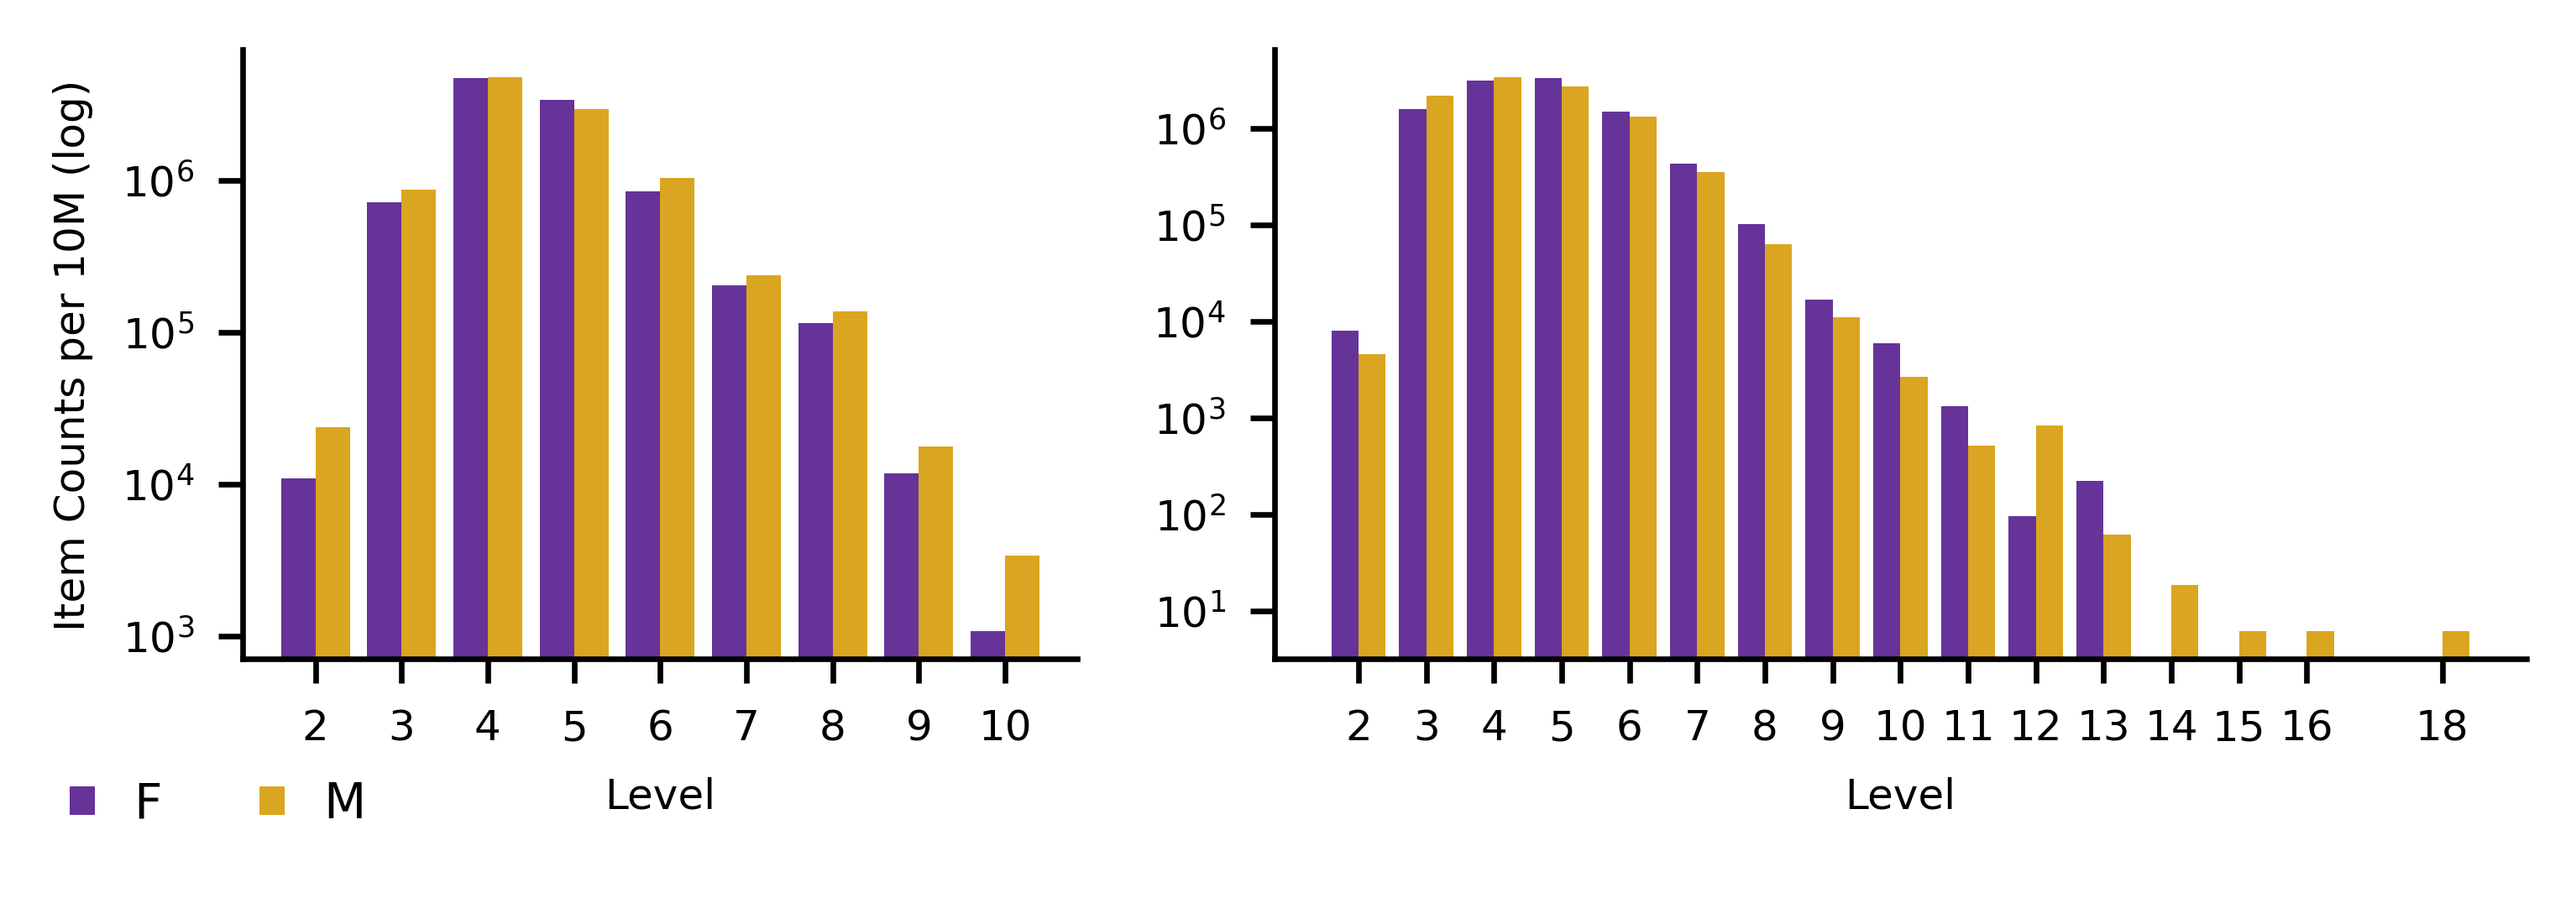

In [31]:
fig = plt.figure(figsize=(5.25, 2), dpi=600.0)
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1, 1.5])
legend_elements = [Patch(facecolor='rebeccapurple', edgecolor='none', label='F'),
                   Patch(facecolor='goldenrod', edgecolor='none', label='M')]
width = 0.4
for i in range(2):
    labels = list(set(f_levels[i]+m_levels[i]))
    level_dat_f = {lev: 0 for lev in labels}
    level_dat_m = {lev: 0 for lev in labels}
    for lev in f_levels[i]:
        level_dat_f[lev] += 1
    for lev in m_levels[i]:
        level_dat_m[lev] += 1
    values_f = [val / sum(list(level_dat_f.values()))*10000000 for val in list(level_dat_f.values())]
    values_m = [val / sum(list(level_dat_m.values()))*10000000 for val in list(level_dat_m.values())]
    ax = fig.add_subplot(spec[0, i])
    ax.bar([i- width/2 for i in labels], values_f, width, label=f'Female', color='rebeccapurple', edgecolor='none')
    ax.bar([i + width/2 for i in labels], values_m, width, label=f'Male', color='goldenrod', edgecolor='none')
    ax.set_xlabel('Level', fontsize=6)
    ax.set_xticks(labels)
    ax.tick_params(axis='both', labelsize=6)
    ax.set_yscale('log')
    ax.minorticks_off()
    if i == 0:
        ax.legend(handles=legend_elements, fontsize=7, handleheight=0.5, handlelength=0.5, 
                    loc="lower right", bbox_to_anchor=(0.2, -0.35), ncol=2, frameon=False)
        ax.set_ylabel('Item Counts per 10M (log)', fontsize=6)

fig.tight_layout()

##### Permutation Test

In [71]:
permTest = True
for i in range(1):
    meanF, meanM = np.mean(f_levels[i]), np.mean(m_levels[i])
    diff = abs(meanF - meanM)
    if permTest:
        p_val = ib.level_perm_test1(f_levels[i]+m_levels[i], len(f_levels[i]), diff, 1000)
        print(f'{SYSTEMS[i]}: {round(diff, 3)} (p={round(p_val, 2)})')
    else:
        print(f'{SYSTEMS[i]}: {round(diff, 3)}')

LCC: 0.001 (p=0.59)


#### Level Bias Statistic 2

The probability that a book by a woman is deeper in the classification system than a book by a man.

In [67]:
permTest = True
probDeeper = []
for i in range(1):
    fDeeper = ib.prob_non_west_deeper(f_levels[i], m_levels[i], 100000)
    probDeeper.append(fDeeper)      
    if permTest:
        p_val = ib.level_perm_test2(f_levels[i] + m_levels[i], len(f_levels[i]), probDeeper[i], 1000)
        print(f'{SYSTEMS[i]}: {round(fDeeper, 2):.2f} (p={round(p_val, 2)})')
    else:
        print(f'{SYSTEMS[i]}: {round(fDeeper, 2):.2f}')

LCC: 0.51 (p=0.32)


### Distributional Bias
Books written by men are more evenly spread throughout the classification system than books written by women. 

In [34]:
validNodesLCC = ib.nodes_with_constraints(lccTree, 100, 2)
validNodesDDC = ib.nodes_with_constraints(ddcTree, 100, 2)
flatterDDC = ib.calc_dist_bias(validNodesDDC)
flatterLCC = ib.calc_dist_bias(validNodesLCC)
flatter = [flatterLCC, flatterDDC]

LCC relative size difference: 1.80
DDC relative size difference: 2.34


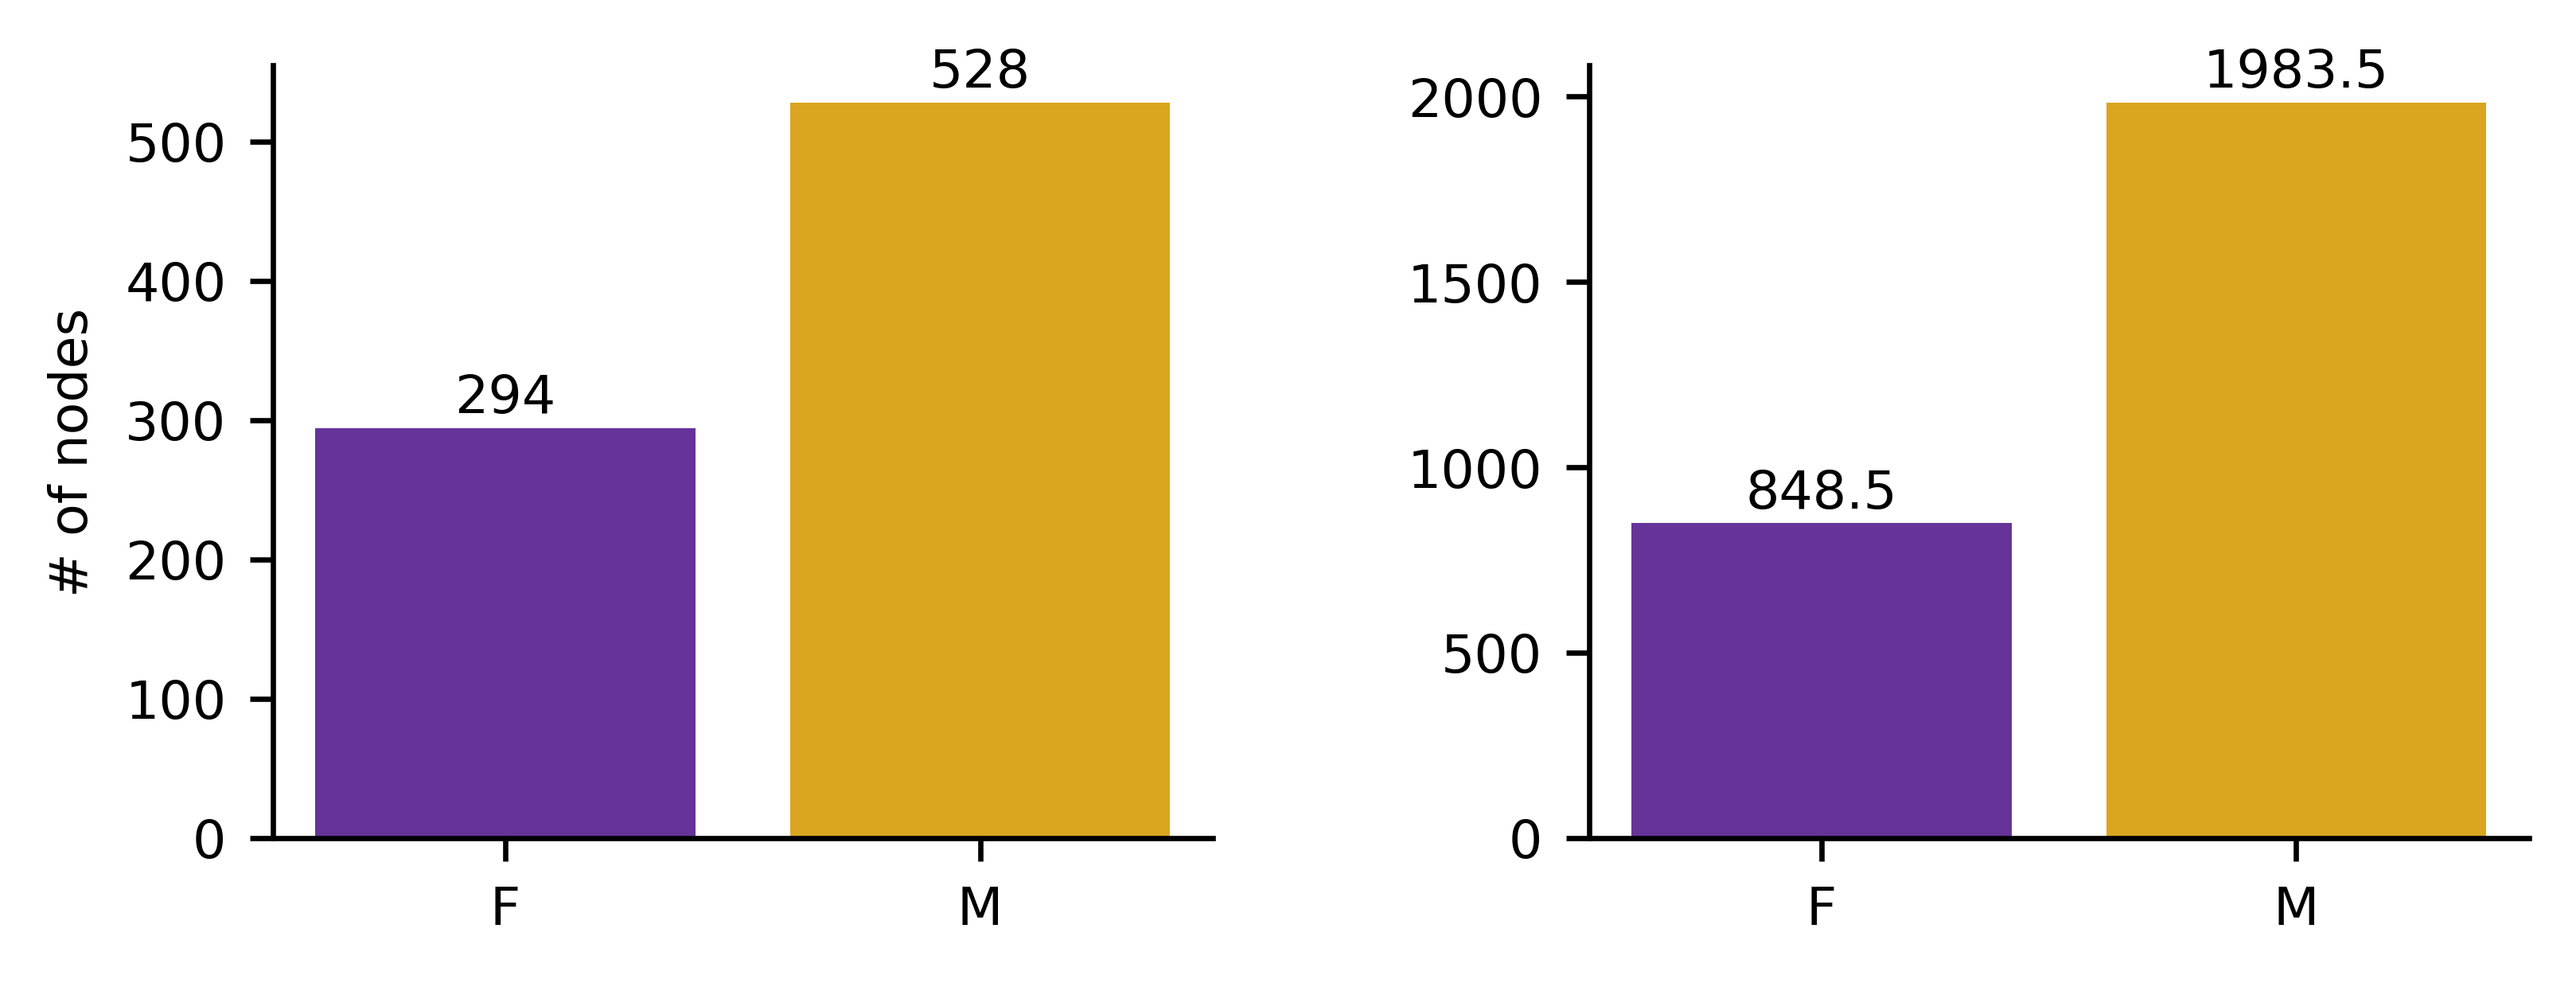

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(5.25, 2.1), dpi=600.0)
for i in range(2):
    ax = axes[i]
    flatterM, flatterF = flatter[i]
    ax.bar([0, 1], [flatterF, flatterM], color=['rebeccapurple', 'goldenrod'])
    fLabel, mLabel = flatterF, flatterM
    if int(flatterF) == float(flatterF):
        fLabel = int(flatterF)
    if int(flatterM) == float(flatterM):
        mLabel = int(flatterM)
    
    ax.text(x=0, y =flatterF+(0.02*ax.get_ylim()[1]) , s=f"{fLabel}" , fontdict=dict(fontsize=8), ha='center')
    ax.text(x=1, y =flatterM+(0.02*ax.get_ylim()[1]) , s=f"{mLabel}" , fontdict=dict(fontsize=8), ha='center')
    ax.set_xticks([0,1])
    ax.set_xticklabels(['F', 'M'], fontsize=8)
    ax.tick_params(axis='y', labelsize=8)

    print(f'{SYSTEMS[i]} relative size difference: {round(flatterM/flatterF, 2):.2f}')
axes[0].set_ylabel('# of nodes', fontsize=8)
plt.subplots_adjust(wspace=0.4, 
                    hspace=0.35,
                    left=0.05,
                    right=0.95)
plt.savefig('figure8-corrected.pdf', bbox_inches='tight')

#### Node Breakdown

In [36]:
trees = [lccTree, ddcTree]
table = []
for i in range(2):
    less_than_2 = ib.get_min_kids(trees[i], 2)
    less_than_100 = ib.get_min_items(trees[i], 100)
    no_women = ib.nodes_without_women(trees[i])
    no_men = ib.nodes_without_men(trees[i])
    valid_nodes = int(sum(flatter[i]))
    total = trees[i].node_count
    row = [SYSTEMS[i], f'{less_than_2:,}', f'{less_than_100:,}', f'{no_women:,}', f'{no_men:,}', f'{valid_nodes:,}', f'{total:,}']
    table.append(row)
print(tabulate(table, headers=['', '< 2 children', '< 100 books', 'No women', ' No men', 'Valid nodes', 'Total']))



     < 2 children    < 100 books    No women       No men  Valid nodes    Total
---  --------------  -------------  ----------  ---------  -------------  -------
LCC  5,858           3,816          1,116              50  822            6,870
DDC  27,668          28,120         8,167             824  2,832          33,751


#### Example
Example distribution of books by men and women in the LCC and DDC

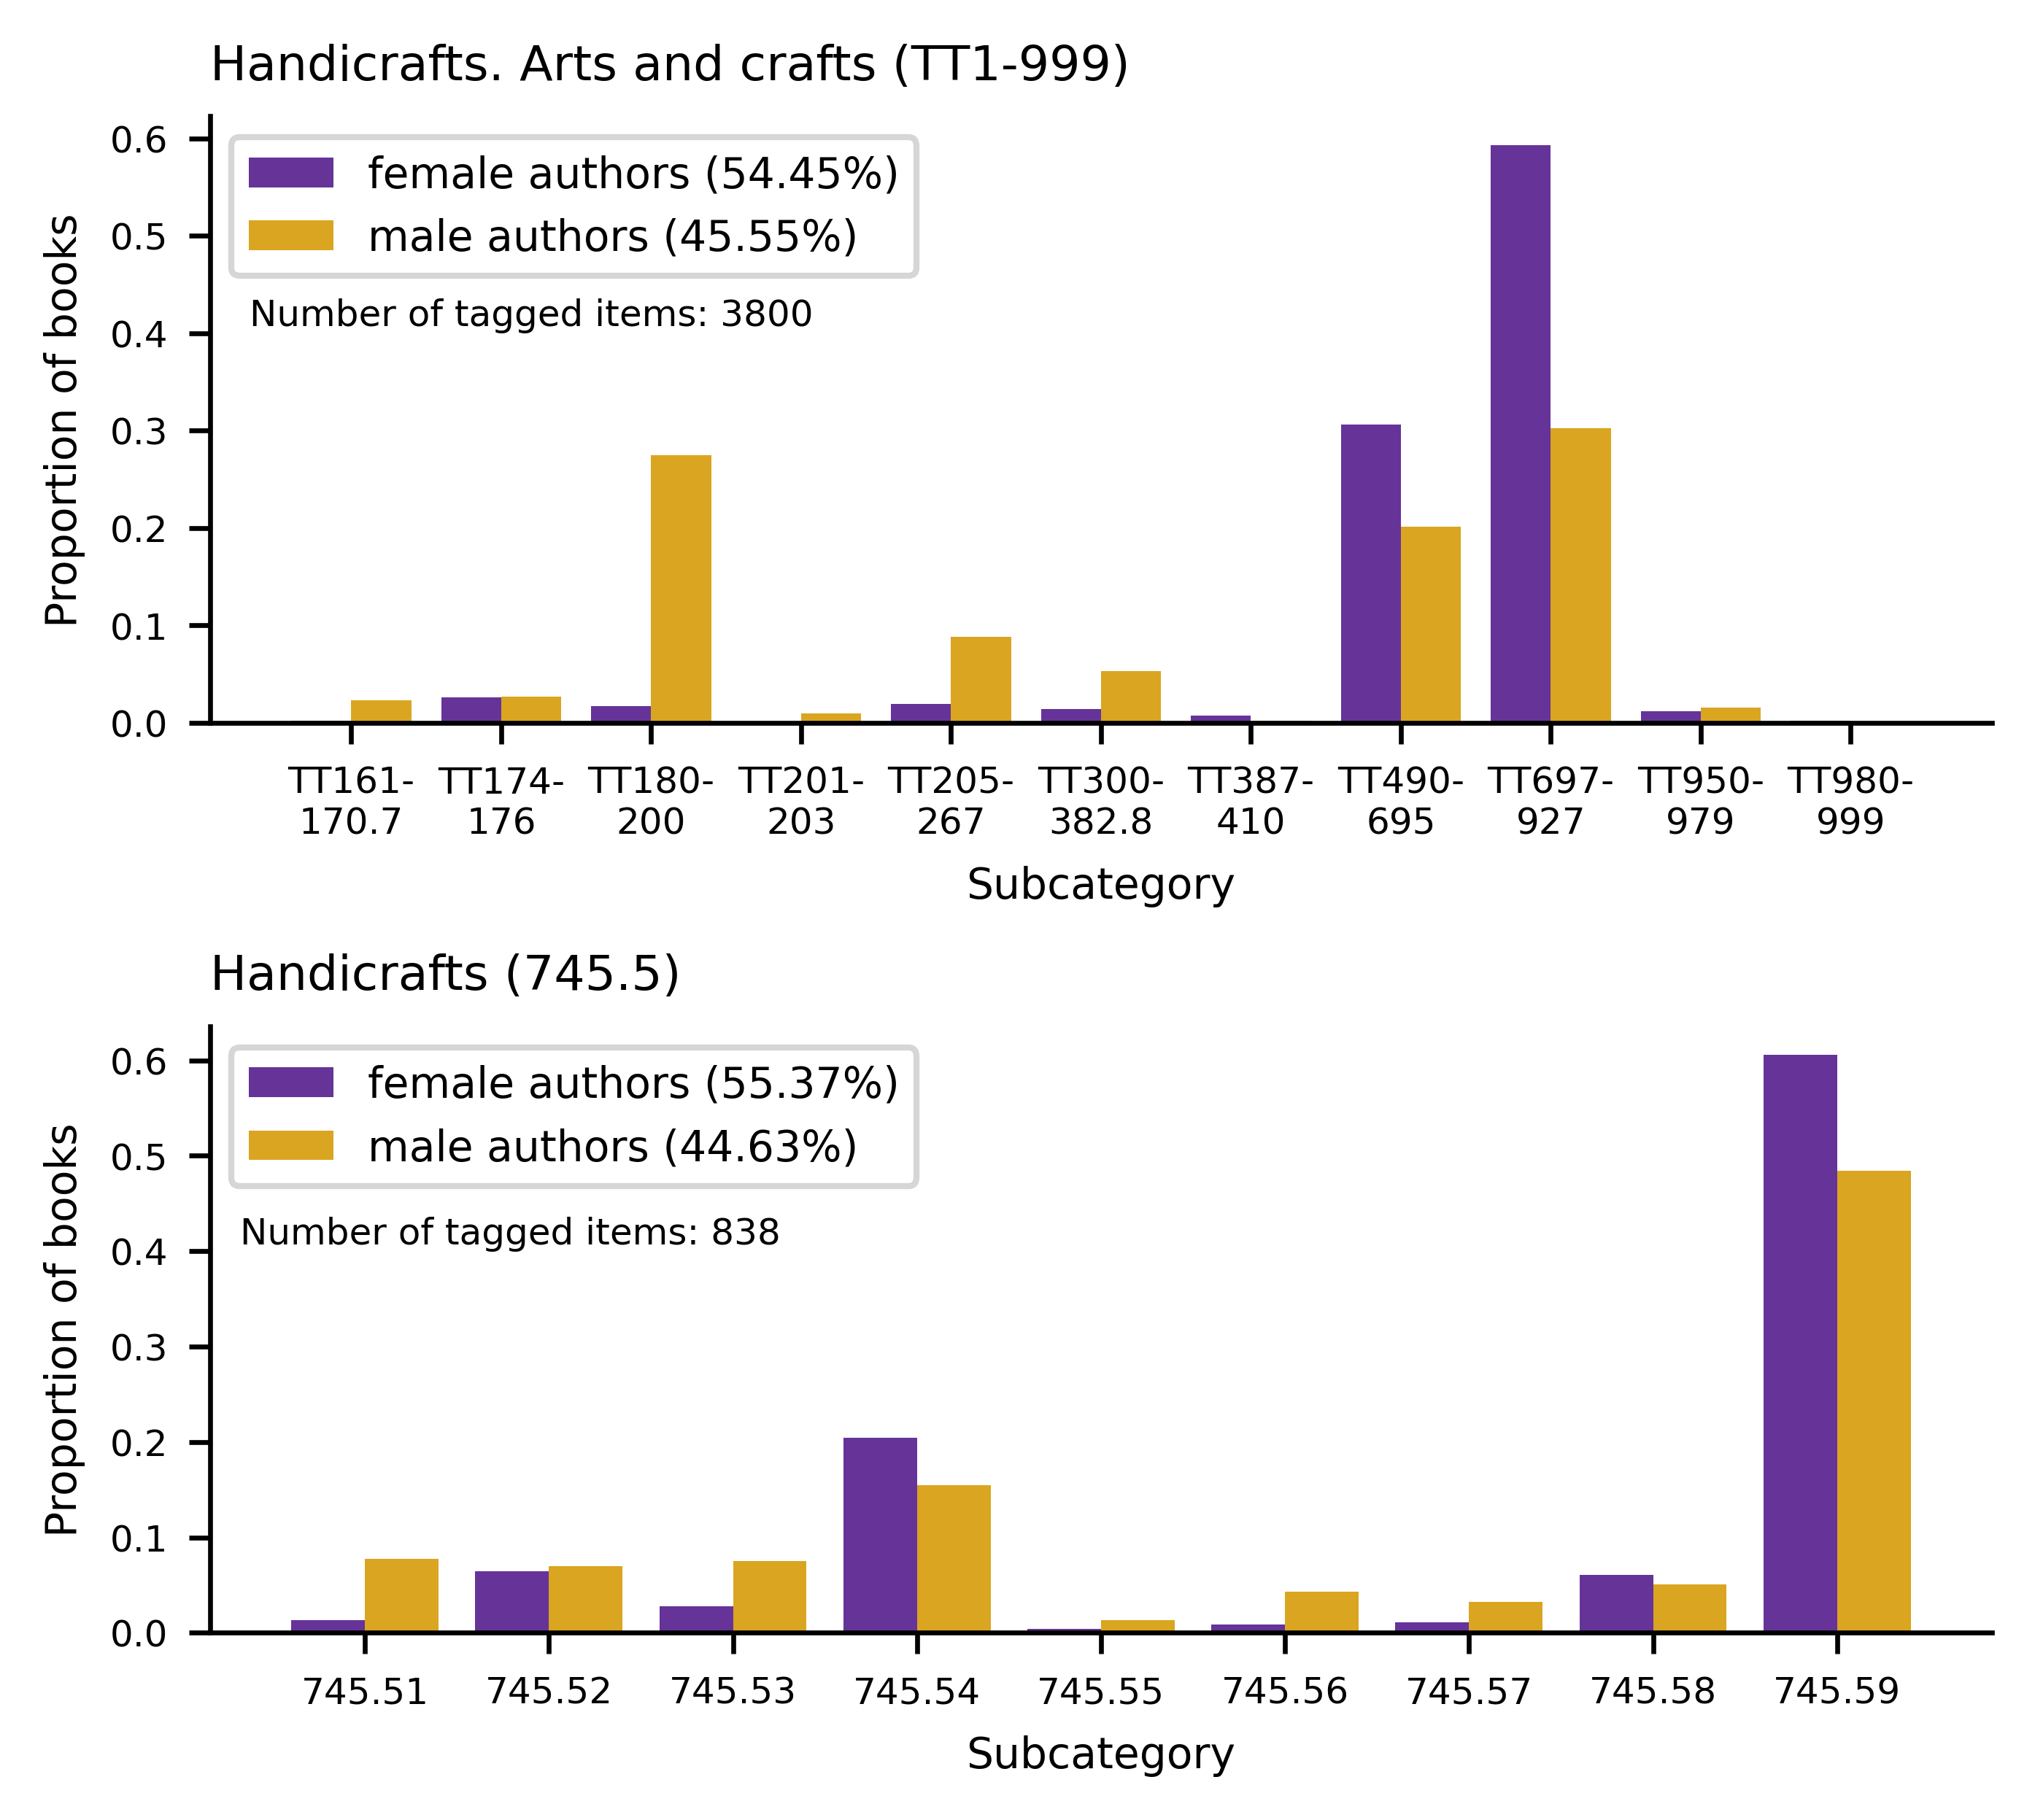

In [37]:
handicrafts = []
diffs_lcc = ib.calc_diff_in_dist(validNodesLCC)
diffs_lcc.sort(key=lambda tup: tup[0], reverse=True)
handicrafts.append(diffs_lcc[19][1])

diffs_ddc = ib.calc_diff_in_dist(validNodesDDC)
diffs_ddc.sort(key=lambda tup: tup[0], reverse=True)
handicrafts.append(diffs_ddc[533][1])

fig, axes = plt.subplots(2, 1, figsize=(5.25, 4.5), dpi=600)
width = 0.4
for i in range(2):
    node = handicrafts[i]
    dist_f, dist_m, sum_f, sum_m = ib.get_fm_dist(node)
    kids = list(node.children.values())
    labels = [kid.label.replace('-', '-\n') for kid in kids]
    x1 = [i - width/2 for i in range(len(labels))]
    x2 = [i + width/2 for i in range(len(labels))]

    ax = axes[i]
    total = sum_f + sum_m
    ax.bar(x1, dist_f, width, label=f'female authors ({round(sum_f/total*100, 2)}%)', color='rebeccapurple')
    ax.bar(x2, dist_m, width, label=f'male authors ({round(sum_m/total*100, 2)}%)', color='goldenrod')
    ax.set_title(f'{node.name} ({node.label})', fontsize=8, loc='left')
    txt = f"Number of tagged items: {total}"#\nDifference in entropy: {round(diff, 2)}"
        
    ax.set_ylabel('Proportion of books', fontsize=7)
    ax.set_xlabel('Subcategory', fontsize=7)
    ax.set_xticks([i for i in range(len(labels))])
    ax.set_xticklabels(labels, fontsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.legend(fontsize=7)    
    ax.text(-0.68,0.4, txt, ha="left", va="bottom", fontsize=6)
plt.subplots_adjust(wspace=0.5, 
              hspace=0.5)


In [ ]:
del f_levels, m_levels, diffs_ddc, diffs_lcc, handicrafts, validNodesLCC, validNodesDDC